Merhaba bu kod tüm eğitimleri içeren ana kod'um ancak daha saonra eğitimleri paralel olarak yapabilmek adına aynı kodu bir kaç defa daha oluşturdum ekstra olarak bu kodları da dosyaya ekliyorum. Diğer kodların buradaki koddan herhangi bir farkı bulunmuyor sadece model ismi değişiyor ve/veya sorudan cevap değil de cevaptan soru tahmini yapıyor. Tüm ana kod'umu bu dosyada bulabilirsiniz.

Saygılarımla,
Tuğcan Topaloğlu

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset

# Turkish Instructions veri setini yükleyin
dataset = load_dataset("merve/turkish_instructions")

# Veri setindeki örnekleri incelemek
print(dataset['train'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

instructions.csv:   0%|          | 0.00/21.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/51563 [00:00<?, ? examples/s]

Dataset({
    features: ['Unnamed: 0', 'talimat', ' giriş', ' çıktı'],
    num_rows: 51563
})


In [ ]:
import random

# Sorular ve cevapları içeren listeler
questions = []
answers = []
# veri seti " giriş" " çıktı" şeklinde key üretiyor
# Veri setinden soruları ve cevapları ayırma
for example in dataset['train']:
    instruction = example['talimat']
    input_text = example[' giriş']
    response = example[' çıktı']

    # Soru oluşturma (talimat + giriş)
    question = f"{instruction} {input_text}".strip()
    answer = response.strip()

    # Listelere ekleme
    questions.append(question)
    answers.append(answer)

# 1000 adet rasgele soru-cevap seçimi
random_indices = random.sample(range(len(questions)), 1000)
selected_questions = [questions[i] for i in random_indices]
selected_answers = [answers[i] for i in random_indices]

In [ ]:
import pandas as pd

# Seçilen sorular ve cevapları bir veri çerçevesine dönüştürme
data = {
    "Question": selected_questions,
    "Answer": selected_answers
}
df = pd.DataFrame(data)

# CSV dosyasına kaydetme
csv_file_path = "selected_questions_answers.csv"
df.to_csv(csv_file_path, index=False)

print(f"Rastgele seçilen 1000 soru ve cevap '{csv_file_path}' dosyasına kaydedildi.")

In [ ]:
from datasets import Dataset
import pandas as pd
df = pd.read_csv("selected_questions_answers.csv")
dataset = Dataset.from_pandas(df)
selected_questions = dataset['Question']
selected_answers = dataset['Answer']

In [ ]:
# ornek soru ve cevap
print("Örnek Soru:", selected_questions[999])
print("Örnek Cevap:", selected_answers[999])

Örnek Soru: En güçlü konuşma biçimini içeren cümleyi seçin.  (1) Fırtına bir canavar gibi şiddetleniyordu. (2) Fırtına bir aslan kadar vahşiydi. (3) Fırtına bir canavar kadar şiddetliydi. (4) Fırtına vahşi bir ejderhaydı.
Örnek Cevap: 4


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# modeli yükleme ve vektör çıkartma
def get_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to("cuda")
    return tokenizer, model

# temsil çıkarma işlevi
def get_embeddings(texts, tokenizer, model):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :]

def get_embeddings_in_batches(texts, tokenizer, model, batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to('cuda')
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu()  # GPU'dan CPU'ya taşıyoruz
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings)


In [ ]:
# ornek model ve tokenizer yükleme
tokenizer, model = get_model_and_tokenizer("dbmdz/bert-base-turkish-cased")

# ornek temsiller çıkarma
embeddings = get_embeddings(selected_questions[:10], tokenizer, model)
print("Örnek Embedding Boyutu:", embeddings.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Örnek Embedding Boyutu: torch.Size([10, 768])


In [ ]:
from scipy.spatial.distance import cosine
import numpy as np

# kosinus benzerliğini hesaplama işlevi
def calculate_similarity(embedding1, embedding2):
    # kosinus mesafesi benzerliğin tersi oldugundan bu nedenle 1-cosine(embedding1, embedding2) olarak hesaplıyoruz
    similarity = 1 - cosine(embedding1, embedding2)
    return similarity

# ornek olarak ilk 10 soru ve cevap arasındaki benzerlikleri hesaplayalım
for i in range(10):
    question_embedding = embeddings[i].cpu().numpy()
    answer_embedding = get_embeddings([selected_answers[i]], tokenizer, model)[0].cpu().numpy()

    similarity = calculate_similarity(question_embedding, answer_embedding)
    print(f"Soru {i + 1} ve Cevap {i + 1} arasındaki benzerlik: {similarity:.4f}")


Soru 1 ve Cevap 1 arasındaki benzerlik: 0.0968
Soru 2 ve Cevap 2 arasındaki benzerlik: 0.1034
Soru 3 ve Cevap 3 arasındaki benzerlik: 0.8325
Soru 4 ve Cevap 4 arasındaki benzerlik: -0.0717
Soru 5 ve Cevap 5 arasındaki benzerlik: 0.3765
Soru 6 ve Cevap 6 arasındaki benzerlik: 0.9769
Soru 7 ve Cevap 7 arasındaki benzerlik: 0.9526
Soru 8 ve Cevap 8 arasındaki benzerlik: 0.7085
Soru 9 ve Cevap 9 arasındaki benzerlik: 0.0528
Soru 10 ve Cevap 10 arasındaki benzerlik: 0.1404


In [ ]:
# top-1 ve top-5 başarı oranı hesaplama islevi
def calculate_top_k_success(questions, answers, tokenizer, model, k=5):
    top1_count = 0
    top5_count = 0

    for idx, question in enumerate(questions):
        question_embedding = get_embeddings([question], tokenizer, model)[0].cpu().numpy()

        # tum cevapların embedding'lerini hesaplayalım
        answer_embeddings = get_embeddings(answers, tokenizer, model).cpu().numpy()

        # soru ile her bir cevap arasındaki benzerlik skorunu hesaplayalım
        similarities = [calculate_similarity(question_embedding, answer) for answer in answer_embeddings]

        # skorlari büyükten küçüğe sıralayalım ve en benzer ilk k cevapları bulalım
        sorted_indices = np.argsort(similarities)[::-1]
        top_k_indices = sorted_indices[:k]

        # gercek cevabın indeksi k içerisinde ise sayacı arttıralım
        # idx = index
        if idx in top_k_indices:
            top5_count += 1
            if top_k_indices[0] == idx:
                top1_count += 1
        # ilk seferde calisip calismadigindan emin olmak icin step sayaci koydum bundan sonraki tum modellerde bu sayaci 50 ser 50 ser arttiriyorum cok fazla otuput olmamasi icin
        print('Step Complete - Index:',idx)
    top1_success_rate = top1_count / len(questions)
    top5_success_rate = top5_count / len(questions)

    return top1_success_rate, top5_success_rate

In [ ]:
# Model 1 - KaLM-embedding-multilingual-mini-v1
# Model 2 - pingkeest/learning2_model
# Model 3 - sentence-transformers/paraphrase-multilingual-mpnet-base-v2
# Model 4 - Alibaba-NLP/gte-multilingual-base
# Model 5 - Alibaba-NLP/gte-large-en-v1.5
# Model 6 - dbmdz/bert-base-turkish-cased

# kullanilacak model isimlerinin listesi
# ilk basta planim sirayla modelleri calistirmakti ancak uzun surmesinden oturu paralel olarak modelleri boldum
# ve kodu bir bir her model icin parelel olarak calistirdim
custom_model_names = [
    "dbmdz/bert-base-turkish-cased"
]

# her model için top-1 ve top-5 başarı oranlarını hesaplayalım
results = {}
for model_name in custom_model_names:
    print(f"Model: {model_name} yükleniyor...")
    tokenizer, model = get_model_and_tokenizer(model_name)

    print(f"{model_name} için top-1 ve top-5 başarı oranları hesaplanıyor...")
    top1_rate, top5_rate = calculate_top_k_success(selected_questions, selected_answers, tokenizer, model)

    results[model_name] = {
        "top1": top1_rate,
        "top5": top5_rate
    }

    print(f"{model_name} - Top-1 Başarı Oranı: {top1_rate:.2%}, Top-5 Başarı Oranı: {top5_rate:.2%}\n")

# sonuclari yazdırma
print("Tüm modellerin başarı oranları:")
for model, scores in results.items():
    print(f"{model} - Top-1: {scores['top1']:.2%}, Top-5: {scores['top5']:.2%}")


Model: dbmdz/bert-base-turkish-cased yükleniyor...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


dbmdz/bert-base-turkish-cased için top-1 ve top-5 başarı oranları hesaplanıyor...
Step Complete IDX: 0
Step Complete IDX: 1
Step Complete IDX: 2
Step Complete IDX: 3
Step Complete IDX: 4
Step Complete IDX: 5
Step Complete IDX: 6
Step Complete IDX: 7
Step Complete IDX: 8
Step Complete IDX: 9
Step Complete IDX: 10
Step Complete IDX: 11
Step Complete IDX: 12
Step Complete IDX: 13
Step Complete IDX: 14
Step Complete IDX: 15
Step Complete IDX: 16
Step Complete IDX: 17
Step Complete IDX: 18
Step Complete IDX: 19
Step Complete IDX: 20
Step Complete IDX: 21
Step Complete IDX: 22
Step Complete IDX: 23
Step Complete IDX: 24
Step Complete IDX: 25
Step Complete IDX: 26
Step Complete IDX: 27
Step Complete IDX: 28
Step Complete IDX: 29
Step Complete IDX: 30
Step Complete IDX: 31
Step Complete IDX: 32
Step Complete IDX: 33
Step Complete IDX: 34
Step Complete IDX: 35
Step Complete IDX: 36
Step Complete IDX: 37
Step Complete IDX: 38
Step Complete IDX: 39
Step Complete IDX: 40
Step Complete IDX: 41
Step

dbmdz/bert-base-turkish-cased için t-SNE görselleştirmesi oluşturuluyor...


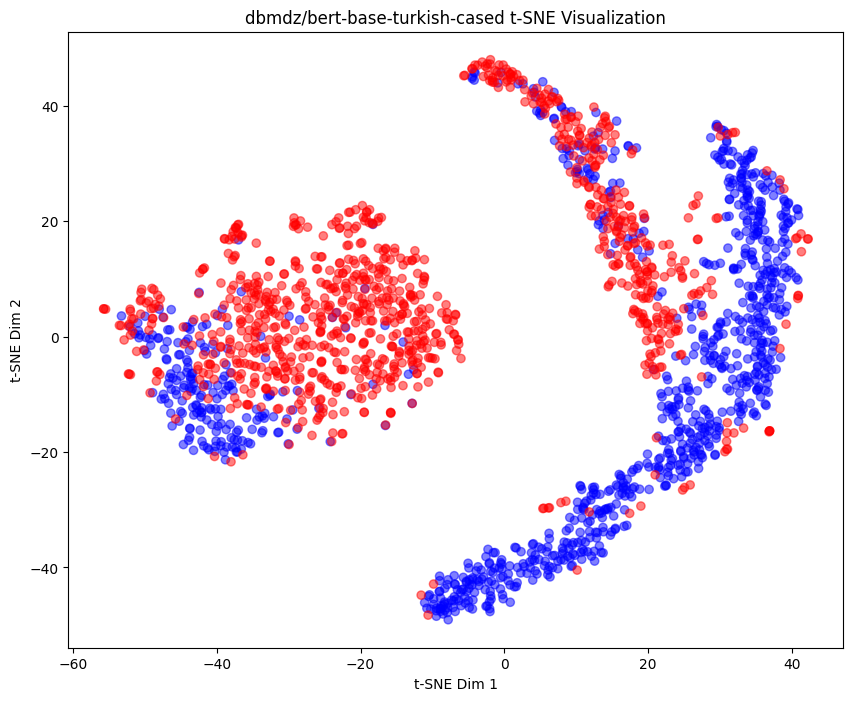

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# t-SNE uygulayarak gorsellestirdim
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)
    colors = ['blue' if label == 'question' else 'red' for label in labels]
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.5)
    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.show()

for model_name in custom_model_names:
    print(f"{model_name} için t-SNE görselleştirmesi oluşturuluyor...")
    tokenizer, model = get_model_and_tokenizer(model_name)

    # embedding alma
    question_embeddings = get_embeddings_in_batches(selected_questions, tokenizer, model).numpy()
    answer_embeddings = get_embeddings_in_batches(selected_answers, tokenizer, model).numpy()

    # t-SNE icin verileri birlestirme
    all_embeddings = np.vstack((question_embeddings, answer_embeddings))
    labels = ['question'] * len(selected_questions) + ['answer'] * len(selected_answers)

    # gorsellestirme
    plot_tsne(all_embeddings, labels, f"{model_name} t-SNE Visualization")
